<a href="https://colab.research.google.com/github/2303A51876/BT-14_1876_Python-for-DS/blob/main/project%20codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial shape: (106987, 15)
After cleaning: (106987, 14)
Sampled to: (8000, 14)
num cols: ['Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'Date.diff', 'wait_days', 'scheduled_hour', 'appointment_dow', 'appointment_is_weekend'] cat cols: ['Gender', 'Neighbourhood']
Processed shape: (8000, 92)


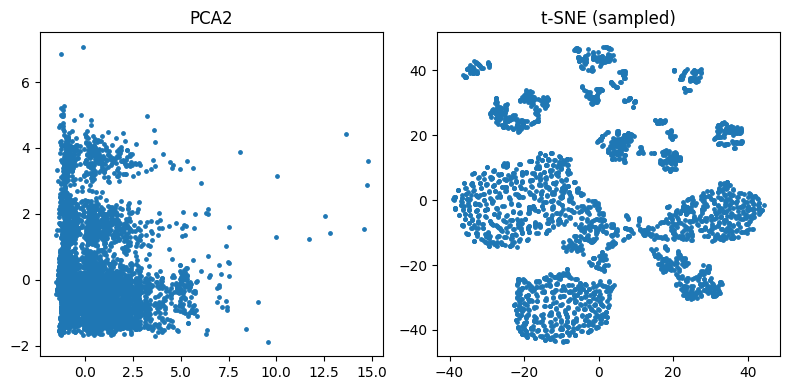

KMeans k 2 sil 0.17289861872282372
KMeans k 3 sil 0.21705866729036916
KMeans k 4 sil 0.2195481221945941
KMeans k 5 sil 0.20569654556007044
KMeans_k4: clusters (excl noise)=4
 silhouette: 0.2195481221945941
 calinski: 1165.4545379398944


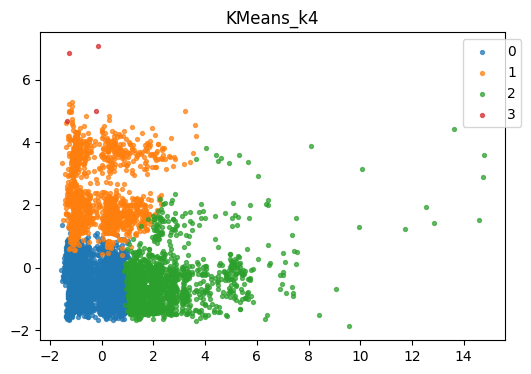

Agglomerative_2: clusters (excl noise)=2
 silhouette: 0.26725152726840135
 calinski: 1005.4534737030928


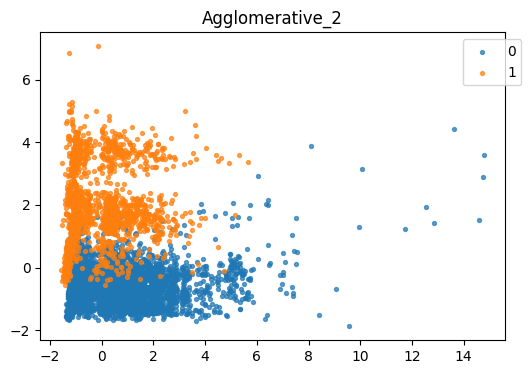

Agglomerative_3: clusters (excl noise)=3
 silhouette: 0.15682284089575443
 calinski: 984.8952160492776


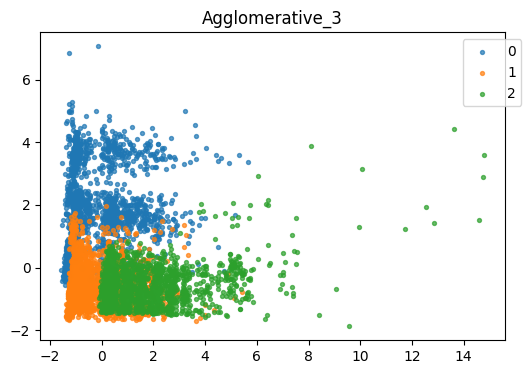

Agglomerative_4: clusters (excl noise)=4
 silhouette: 0.16053863581510094
 calinski: 1028.1434261606614


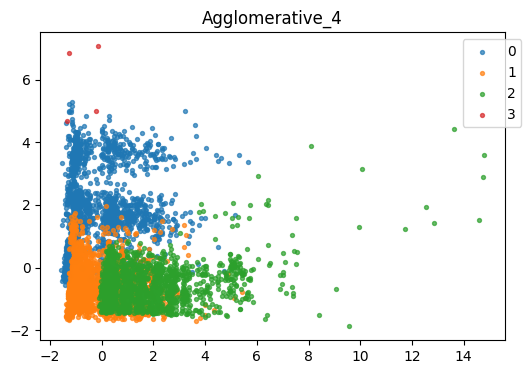

DBSCAN: clusters (excl noise)=37
 silhouette: -0.33512151378614635
 calinski: 4.9952210268433985


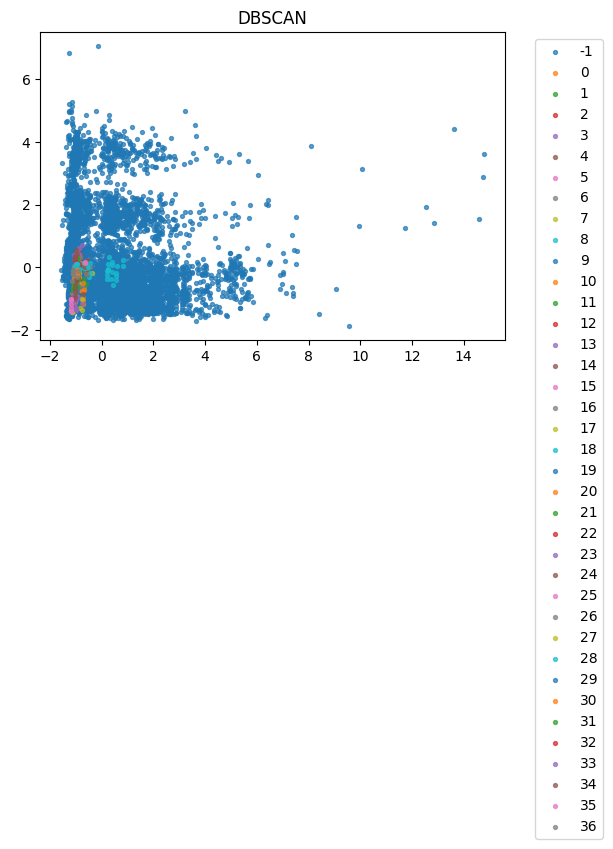

GMM_2: clusters (excl noise)=2
 silhouette: 0.016396546842989416
 calinski: 71.31693106634616


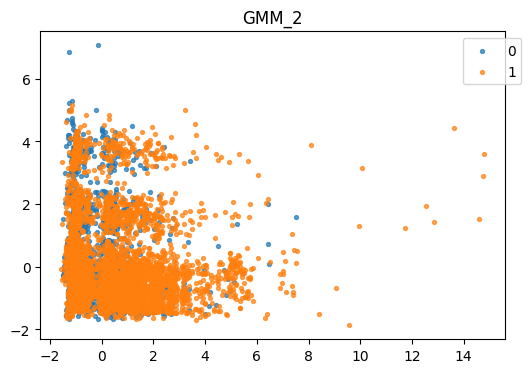

GMM_3: clusters (excl noise)=3
 silhouette: -0.05519196763289814
 calinski: 87.73849821166614


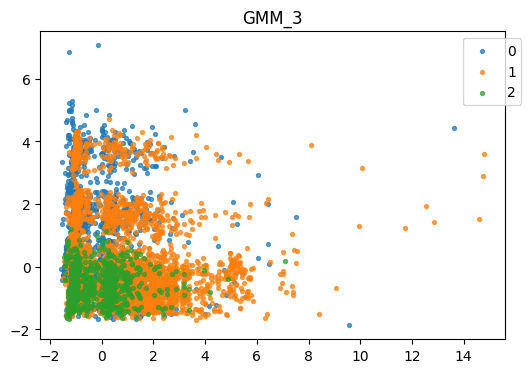

GMM_4: clusters (excl noise)=4
 silhouette: -0.004939857792203373
 calinski: 371.5893663500757


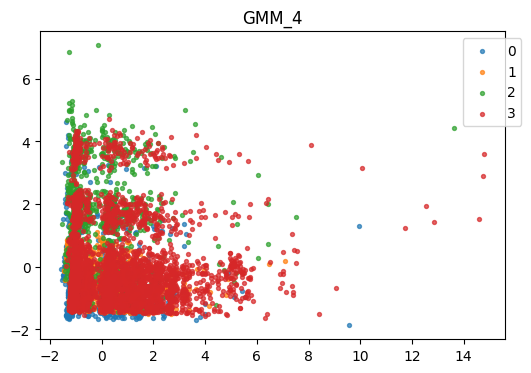

IsolationForest outliers: 0


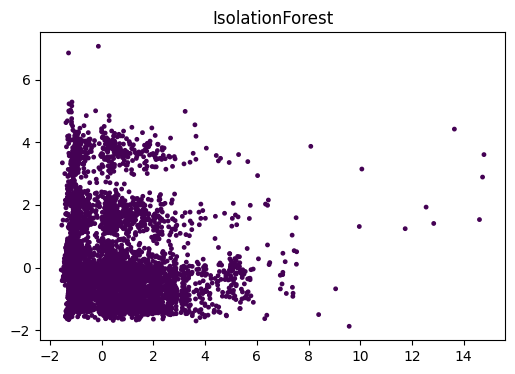

LOF outliers: 37


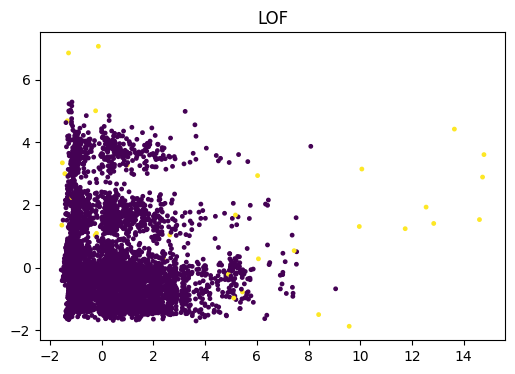

Saved processed features to outputs_unsupervised


In [1]:
# ========== Unsupervised end-to-end (Colab-friendly) ==========
# Save as unsupervised_noshows.py or run as a Colab cell.

import os, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# optional UMAP (install umap-learn if desired)
HAS_UMAP = False
try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

# ---------------- CONFIG ----------------
CSV_PATH = "healthcare_noshows.csv"
OUTDIR = "outputs_unsupervised"
os.makedirs(OUTDIR, exist_ok=True)
LIGHT_MODE = True
SAMPLE_SIZE = 8000 if LIGHT_MODE else None
TSNE_SAMPLE = 3000 if LIGHT_MODE else 10000

# ---------------- LOAD & CLEAN ----------------
df = pd.read_csv(CSV_PATH)
print("Initial shape:", df.shape)
# drop label columns if exist (unsupervised)
for t in ["Showed_up","No-show","NoShow","No_show","ShowedUp"]:
    if t in df.columns:
        df = df.drop(columns=[t], errors="ignore")
# drop ids
for c in ["PatientId","PatientID","AppointmentID","AppointmentId"]:
    if c in df.columns:
        df = df.drop(columns=[c])
# rename typos
if "Hipertension" in df.columns: df = df.rename(columns={"Hipertension":"Hypertension"})
if "Handcap" in df.columns: df = df.rename(columns={"Handcap":"Handicap"})
# parse dates & engineer features
for date_col in ["ScheduledDay","AppointmentDay"]:
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
if set(["ScheduledDay","AppointmentDay"]).issubset(df.columns):
    df["wait_days"] = (df["AppointmentDay"].dt.normalize() - df["ScheduledDay"].dt.normalize()).dt.days
    df["wait_days"] = df["wait_days"].clip(lower=0).fillna(0).astype(int)
    df["scheduled_hour"] = df["ScheduledDay"].dt.hour.fillna(0).astype(int)
    df["appointment_dow"] = df["AppointmentDay"].dt.dayofweek.fillna(0).astype(int)
    df["appointment_is_weekend"] = (df["appointment_dow"] >= 5).astype(int)
df = df.drop(columns=["ScheduledDay","AppointmentDay"], errors="ignore")
for col in ["Hypertension","Diabetes","Alcoholism","Handicap","Scholarship","SMS_received"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int).clip(lower=0)
if "Age" in df.columns:
    df = df[(df["Age"] >= 0) & (df["Age"] <= 120)]

print("After cleaning:", df.shape)

# ---------------- SAMPLE for speed ----------------
if LIGHT_MODE and SAMPLE_SIZE is not None and len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print("Sampled to:", df.shape)

# ---------------- ENCODE & SCALE ----------------
X = df.copy()
cat_cols = [c for c in X.columns if X[c].dtype == 'O']
num_cols = [c for c in X.columns if c not in cat_cols]
print("num cols:", num_cols, "cat cols:", cat_cols)

numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
preproc = ColumnTransformer([("num", numeric_transformer, num_cols), ("cat", categorical_transformer, cat_cols)], remainder="drop")
X_proc = preproc.fit_transform(X)
print("Processed shape:", X_proc.shape)

# save processed features
pd.DataFrame(X_proc).to_csv(os.path.join(OUTDIR,"processed_features.csv"), index=False)

# ---------------- DIM REDUCTION (for viz) ----------------
pca = PCA(n_components=2, random_state=42)
X_pca2 = pca.fit_transform(X_proc)

# t-SNE (sampled for speed)
if LIGHT_MODE:
    idx = np.random.choice(len(X_proc), size=min(TSNE_SAMPLE,len(X_proc)), replace=False)
    X_tsne2 = TSNE(n_components=2, perplexity=30, n_iter=600, random_state=42, init='pca').fit_transform(X_proc[idx])
else:
    X_tsne2 = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca').fit_transform(X_proc)

# optional UMAP
if HAS_UMAP:
    if LIGHT_MODE:
        um_idx = np.random.choice(len(X_proc), size=min(5000,len(X_proc)), replace=False)
        X_umap2 = umap.UMAP(n_components=2, random_state=42).fit_transform(X_proc[um_idx])
    else:
        X_umap2 = umap.UMAP(n_components=2, random_state=42).fit_transform(X_proc)
else:
    X_umap2 = None

# plot PCA overview
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.scatter(X_pca2[:,0], X_pca2[:,1], s=6); plt.title("PCA2")
plt.subplot(1,2,2); plt.scatter(X_tsne2[:,0], X_tsne2[:,1], s=6); plt.title("t-SNE (sampled)")
plt.tight_layout(); plt.show()

# ---------------- CLUSTERING ----------------
def eval_and_plot(name, labels, embed=X_pca2):
    labels = np.array(labels)
    nclusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"{name}: clusters (excl noise)={nclusters}")
    try:
        if nclusters >= 2:
            print(" silhouette:", silhouette_score(X_proc, labels))
            print(" calinski:", calinski_harabasz_score(X_proc, labels))
    except Exception as e:
        print(" metric error:", e)
    # plot
    plt.figure(figsize=(6,4))
    for lab in np.unique(labels):
        mask = labels==lab
        plt.scatter(embed[mask,0], embed[mask,1], s=8, label=str(lab), alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05,1)); plt.title(name); plt.show()

# KMeans (small range)
sil_scores = {}
for k in [2,3,4,5]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(X_proc)
    try: sil = silhouette_score(X_proc, labs)
    except: sil = np.nan
    sil_scores[k] = sil
    print("KMeans k",k,"sil",sil)
best_k = max([k for k,v in sil_scores.items() if not np.isnan(v)], key=lambda kk: sil_scores[kk]) if any(not np.isnan(v) for v in sil_scores.values()) else 3
km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
klabels = km.fit_predict(X_proc)
eval_and_plot(f"KMeans_k{best_k}", klabels)

# Agglomerative small sizes
for n in [2,3,4]:
    ac = AgglomerativeClustering(n_clusters=n)
    labs = ac.fit_predict(X_proc)
    eval_and_plot(f"Agglomerative_{n}", labs)

# DBSCAN only if not huge (skip heavy)
if len(X_proc) <= 10000:
    db = DBSCAN(eps=0.5, min_samples=8)
    dlab = db.fit_predict(X_proc)
    eval_and_plot("DBSCAN", dlab)
else:
    print("Skipping DBSCAN (large sample).")

# GMM small
for n in [2,3,4]:
    gm = GaussianMixture(n_components=n, random_state=42, n_init=2)
    labs = gm.fit_predict(X_proc)
    eval_and_plot(f"GMM_{n}", labs)

# ---------------- ANOMALY DETECTION ----------------
iso = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
iso_labs = iso.fit_predict(X_proc)   # -1 outlier, 1 inlier
iso_flag = (iso_labs == -1).astype(int)
print("IsolationForest outliers:", int(iso_flag.sum()))
plt.figure(figsize=(6,4)); plt.scatter(X_pca2[:,0], X_pca2[:,1], c=iso_flag, s=6); plt.title("IsolationForest"); plt.show()

lof = LocalOutlierFactor(n_neighbors=20, contamination="auto")
lof_labs = lof.fit_predict(X_proc)
lof_flag = (lof_labs == -1).astype(int)
print("LOF outliers:", int(lof_flag.sum()))
plt.figure(figsize=(6,4)); plt.scatter(X_pca2[:,0], X_pca2[:,1], c=lof_flag, s=6); plt.title("LOF"); plt.show()

# save outputs
pd.DataFrame(X_proc).to_csv(os.path.join(OUTDIR,"processed_features.csv"), index=False)
print("Saved processed features to", OUTDIR)

Initial shape: (106987, 15)
Columns: ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up', 'Date.diff']
After cleaning: (106987, 15)
Sampled to: (20000, 15)
Numeric cols: ['Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'Date.diff', 'wait_days', 'scheduled_hour', 'appointment_dow', 'appointment_is_weekend']
Categorical cols: ['Gender', 'Neighbourhood']

=== LogisticRegression ===
CV acc: 0.6437 ± 0.0052
Test acc: 0.6428 P/R/F1 (missed=1): (0.2972, 0.5631, 0.3891) AUC: 0.6488
Classification report:
               precision    recall  f1-score   support

           0     0.8570    0.6629    0.7476      3192
           1     0.2972    0.5631    0.3891       808

    accuracy                         0.6428      4000
   macro avg     0.5771    0.6130    0.5683      4000
weighted avg     0.7439    0.6428    0

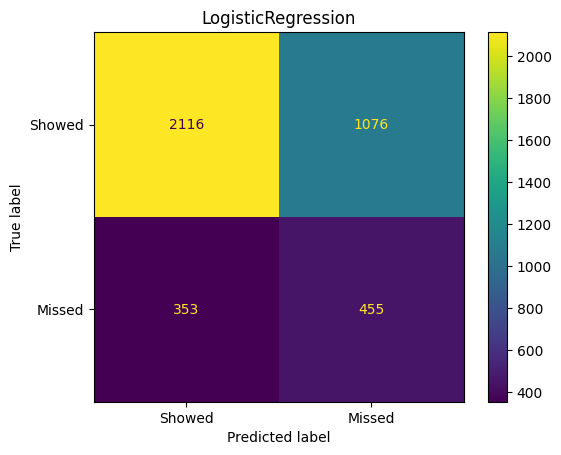


=== DecisionTree ===
CV acc: 0.7012 ± 0.0039
Test acc: 0.6993 P/R/F1 (missed=1): (0.2914, 0.3416, 0.3145) AUC: 0.5663
Classification report:
               precision    recall  f1-score   support

           0     0.8257    0.7898    0.8074      3192
           1     0.2914    0.3416    0.3145       808

    accuracy                         0.6993      4000
   macro avg     0.5586    0.5657    0.5609      4000
weighted avg     0.7178    0.6993    0.7078      4000



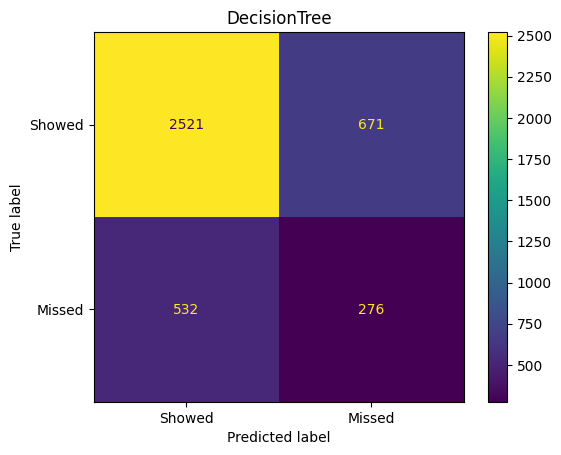


=== RandomForest ===
CV acc: 0.7809 ± 0.0028
Test acc: 0.7808 P/R/F1 (missed=1): (0.3869, 0.146, 0.212) AUC: 0.6874
Classification report:
               precision    recall  f1-score   support

           0     0.8133    0.9414    0.8727      3192
           1     0.3869    0.1460    0.2120       808

    accuracy                         0.7808      4000
   macro avg     0.6001    0.5437    0.5423      4000
weighted avg     0.7271    0.7808    0.7392      4000



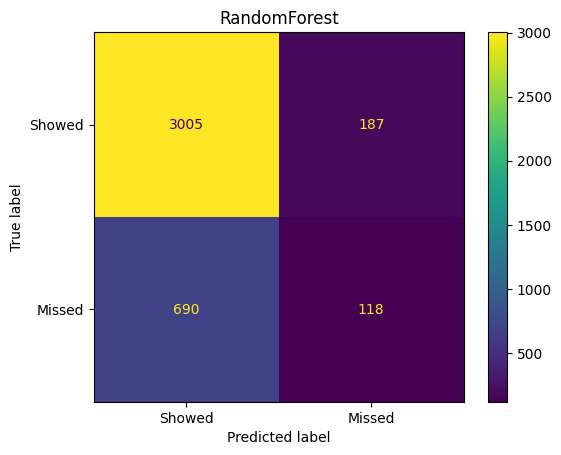


=== KNN ===
CV acc: 0.7773 ± 0.0016
Test acc: 0.7785 P/R/F1 (missed=1): (0.3333, 0.0965, 0.1497) AUC: 0.6121
Classification report:
               precision    recall  f1-score   support

           0     0.8062    0.9511    0.8727      3192
           1     0.3333    0.0965    0.1497       808

    accuracy                         0.7785      4000
   macro avg     0.5697    0.5238    0.5112      4000
weighted avg     0.7106    0.7785    0.7266      4000



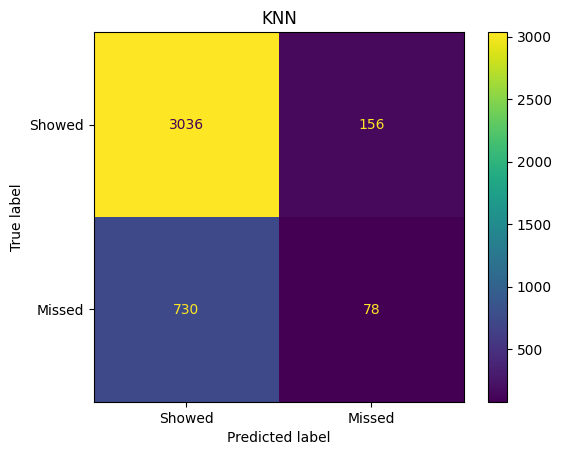


=== SVM ===
CV acc: 0.6275 ± 0.0107
Test acc: 0.6312 P/R/F1 (missed=1): (0.3108, 0.6782, 0.4263) AUC: 0.6961
Classification report:
               precision    recall  f1-score   support

           0     0.8838    0.6194    0.7283      3192
           1     0.3108    0.6782    0.4263       808

    accuracy                         0.6312      4000
   macro avg     0.5973    0.6488    0.5773      4000
weighted avg     0.7680    0.6312    0.6673      4000



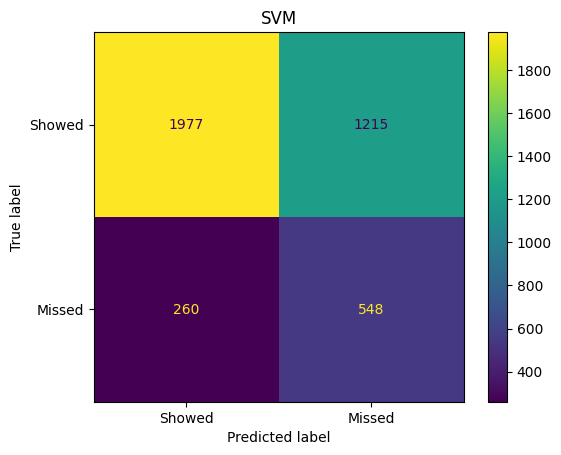


=== GradientBoosting ===
CV acc: 0.7971 ± 0.0012
Test acc: 0.7987 P/R/F1 (missed=1): (0.6, 0.0111, 0.0219) AUC: 0.7166
Classification report:
               precision    recall  f1-score   support

           0     0.7995    0.9981    0.8878      3192
           1     0.6000    0.0111    0.0219       808

    accuracy                         0.7987      4000
   macro avg     0.6997    0.5046    0.4549      4000
weighted avg     0.7592    0.7987    0.7129      4000



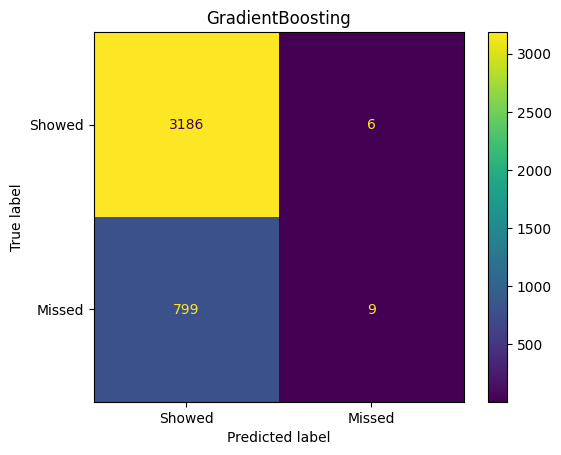


=== AdaBoost ===
CV acc: 0.7980 ± 0.0001
Test acc: 0.798 P/R/F1 (missed=1): (0.0, 0.0, 0.0) AUC: 0.716
Classification report:
               precision    recall  f1-score   support

           0     0.7980    1.0000    0.8877      3192
           1     0.0000    0.0000    0.0000       808

    accuracy                         0.7980      4000
   macro avg     0.3990    0.5000    0.4438      4000
weighted avg     0.6368    0.7980    0.7083      4000



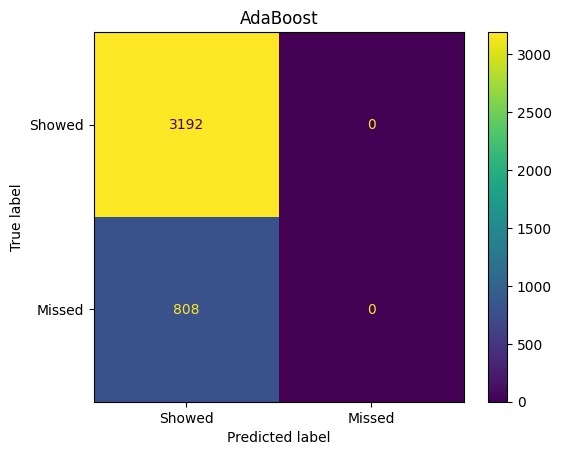


=== GaussianNB ===
CV acc: 0.2414 ± 0.0093
Test acc: 0.2695 P/R/F1 (missed=1): (0.2024, 0.8899, 0.3298) AUC: 0.5447
Classification report:
               precision    recall  f1-score   support

           0     0.8013    0.1125    0.1973      3192
           1     0.2024    0.8899    0.3298       808

    accuracy                         0.2695      4000
   macro avg     0.5019    0.5012    0.2635      4000
weighted avg     0.6804    0.2695    0.2240      4000



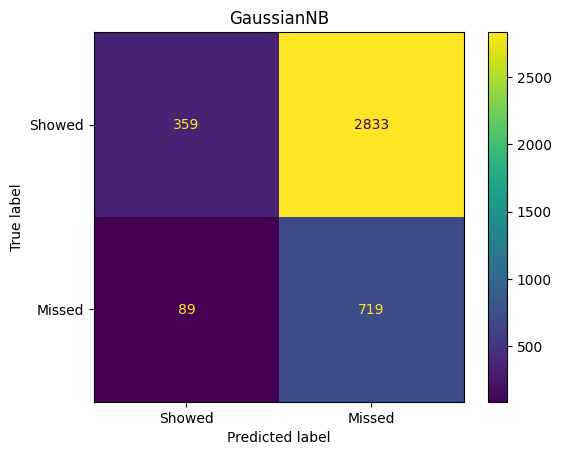


=== XGBoost ===
CV acc: 0.7922 ± 0.0014
Test acc: 0.7957 P/R/F1 (missed=1): (0.4563, 0.0582, 0.1032) AUC: 0.707
Classification report:
               precision    recall  f1-score   support

           0     0.8047    0.9825    0.8848      3192
           1     0.4563    0.0582    0.1032       808

    accuracy                         0.7957      4000
   macro avg     0.6305    0.5203    0.4940      4000
weighted avg     0.7343    0.7957    0.7269      4000



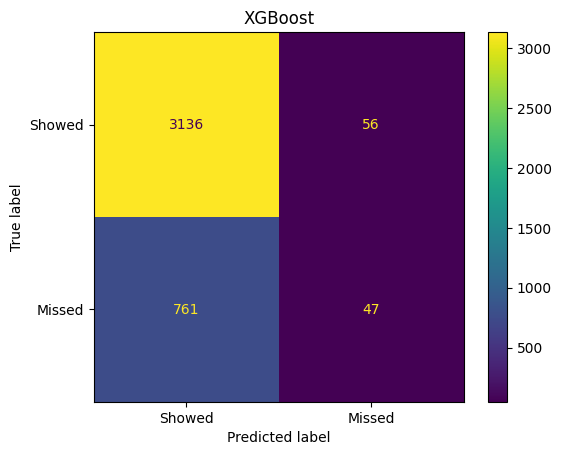


Model comparison (sorted by test acc):
                     test_acc  precision    recall        f1       auc
model                                                                
GradientBoosting     0.79875   0.600000  0.011139  0.021871  0.716636
AdaBoost             0.79800   0.000000  0.000000  0.000000  0.715971
XGBoost              0.79575   0.456311  0.058168  0.103183  0.707014
RandomForest         0.78075   0.386885  0.146040  0.212040  0.687354
KNN                  0.77850   0.333333  0.096535  0.149712  0.612071
DecisionTree         0.69925   0.291447  0.341584  0.314530  0.566309
LogisticRegression   0.64275   0.297191  0.563119  0.389055  0.648795
SVM                  0.63125   0.310834  0.678218  0.426293  0.696132
GaussianNB           0.26950   0.202421  0.889851  0.329817  0.544717
Saved summary to outputs_supervised


In [2]:
# ========== Supervised end-to-end (Colab-friendly) ==========
# Save as supervised_noshows.py or paste into one Colab cell.

import os, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score, ConfusionMatrixDisplay

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ---------------- CONFIG ----------------
CSV_PATH = "healthcare_noshows.csv"
LIGHT_MODE = True        # Fast experiments: True. Set to False to run full experiments.
SAMPLE_SIZE = 20000 if LIGHT_MODE else None
CV_FOLDS = 3 if LIGHT_MODE else 5
RF_TREES = 50 if LIGHT_MODE else 300
XGB_TREES = 50 if (LIGHT_MODE and HAS_XGB) else (300 if HAS_XGB else None)
OUTDIR = "outputs_supervised"
os.makedirs(OUTDIR, exist_ok=True)

# ---------------- LOAD ----------------
df = pd.read_csv(CSV_PATH)
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# ---------------- TARGET SETUP ----------------
# Your dataset uses 'Showed_up' (1 = attended). We want target 'missed' with 1 = Missed, 0 = Attended.
if "Showed_up" in df.columns:
    df = df.dropna(subset=["Showed_up"])
    df["Showed_up"] = df["Showed_up"].astype(int)
    df["missed"] = df["Showed_up"].map({1:0, 0:1})
    target = "missed"
else:
    raise ValueError("Expected 'Showed_up' column in CSV.")

# drop original attended column
if "Showed_up" in df.columns and target == "missed":
    df = df.drop(columns=["Showed_up"])

# ---------------- CLEANING & FEATURE ENGINEERING ----------------
# drop IDs
for c in ["PatientId","PatientID","AppointmentID","AppointmentId"]:
    if c in df.columns:
        df = df.drop(columns=[c])

# rename typos
if "Hipertension" in df.columns: df = df.rename(columns={"Hipertension":"Hypertension"})
if "Handcap" in df.columns: df = df.rename(columns={"Handcap":"Handicap"})

# parse datetimes
for date_col in ["ScheduledDay","AppointmentDay"]:
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# engineer wait_days and time features if possible
if set(["ScheduledDay","AppointmentDay"]).issubset(df.columns):
    df["wait_days"] = (df["AppointmentDay"].dt.normalize() - df["ScheduledDay"].dt.normalize()).dt.days
    df["wait_days"] = df["wait_days"].clip(lower=0).fillna(0).astype(int)
    df["scheduled_hour"] = df["ScheduledDay"].dt.hour.fillna(0).astype(int)
    df["appointment_dow"] = df["AppointmentDay"].dt.dayofweek.fillna(0).astype(int)
    df["appointment_is_weekend"] = (df["appointment_dow"] >= 5).astype(int)

# drop raw datetimes to avoid dtype issues
df = df.drop(columns=["ScheduledDay","AppointmentDay"], errors="ignore")

# safe numeric conversions for binary columns
for col in ["Hypertension","Diabetes","Alcoholism","Handicap","Scholarship","SMS_received"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int).clip(lower=0)

# Age filter
if "Age" in df.columns:
    df = df[(df["Age"] >= 0) & (df["Age"] <= 120)]

print("After cleaning:", df.shape)

# ---------------- SAMPLING for LIGHT MODE ----------------
if LIGHT_MODE and SAMPLE_SIZE is not None and len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print("Sampled to:", df.shape)

# ---------------- PREP & SPLIT ----------------
y = df[target]
X = df.drop(columns=[target])

cat_cols = [c for c in X.columns if X[c].dtype == 'O']
num_cols = [c for c in X.columns if c not in cat_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

numeric_transformer = Pipeline([("scaler", StandardScaler(with_mean=False))])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))])

preproc = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop", sparse_threshold=0.3)

# ---------------- MODELS ----------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=RF_TREES, random_state=42, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GaussianNB": GaussianNB()
}
if HAS_XGB:
    models["XGBoost"] = XGBClassifier(n_estimators=XGB_TREES, use_label_encoder=False, eval_metric="logloss", random_state=42)

# ---------------- TRAIN / EVAL ----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

cv = CV_FOLDS
results = []
for name, clf in models.items():
    print(f"\n=== {name} ===")
    # pipeline, handling GaussianNB dense requirement
    if name == "GaussianNB":
        model = Pipeline([("prep", preproc),
                          ("to_dense", type("ToDense", (), {"fit": lambda self,X,y=None:self, "transform": lambda self,X: X.toarray() if hasattr(X,"toarray") else X})()),
                          ("clf", clf)])
    else:
        model = Pipeline([("prep", preproc), ("clf", clf)])
    # try cross-val (fast or skipped on error)
    try:
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
        print("CV acc: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))
    except Exception as e:
        print("CV skipped/error:", e)
    # fit on train & evaluate
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except Exception:
        y_prob = None
    acc = accuracy_score(y_test, y_pred)
    p,r,f1,_ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    print("Test acc:", round(acc,4), "P/R/F1 (missed=1):", (round(p,4),round(r,4),round(f1,4)), "AUC:", (round(auc,4) if not np.isnan(auc) else "N/A"))
    print("Classification report:\n", classification_report(y_test, y_pred, digits=4))
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Showed","Missed"]).plot()
    plt.title(name); plt.show()
    results.append({"model":name,"test_acc":acc,"precision":p,"recall":r,"f1":f1,"auc":auc})

# ---------------- SUMMARY ----------------
res_df = pd.DataFrame(results).set_index("model").sort_values("test_acc", ascending=False)
print("\nModel comparison (sorted by test acc):\n", res_df)
res_df.to_csv(os.path.join(OUTDIR,"model_comparison.csv"))
print("Saved summary to", OUTDIR)

Initial shape: (106987, 15)
Columns: ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up', 'Date.diff']
Sampled to: (8000, 16)
Simulator features: ['Age', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'wait_days', 'scheduled_hour', 'appointment_is_weekend']
Simulator model ROC-AUC (train): 0.6500116733456859

Running experiments...


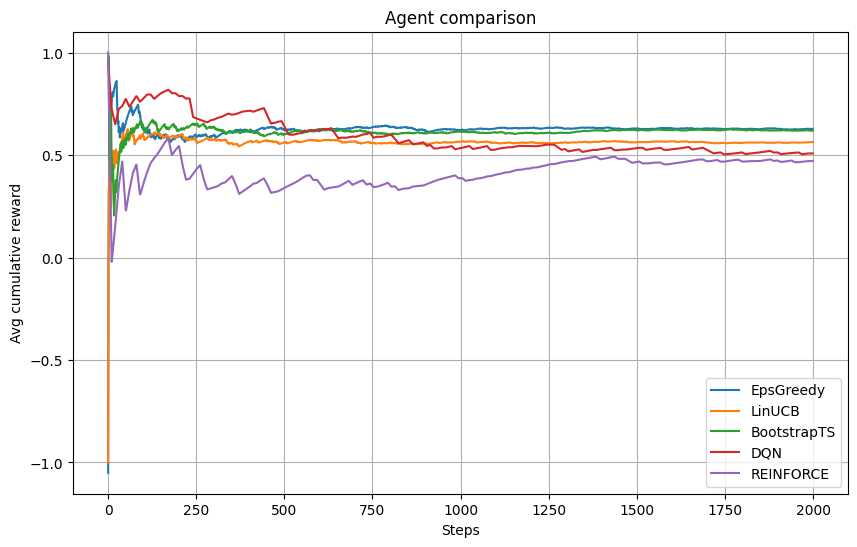


Sample policy suggestions:
idx 4505 greedy: NoAction  qvals: [0.518 0.511 0.558 0.622]  pol: [0.347 0.151 0.243 0.26 ]
idx 2373 greedy: SendSMS  qvals: [0.634 0.231 0.084 0.316]  pol: [0.38  0.126 0.262 0.231]
idx 4848 greedy: NoAction  qvals: [0.522 0.614 0.381 0.6  ]  pol: [0.314 0.185 0.237 0.264]
idx 681 greedy: NoAction  qvals: [1.109 0.825 0.659 0.558]  pol: [0.367 0.081 0.255 0.298]
idx 6297 greedy: NoAction  qvals: [0.734 0.844 0.315 0.537]  pol: [0.314 0.162 0.227 0.296]
idx 4392 greedy: NoAction  qvals: [0.465 0.155 0.389 0.761]  pol: [0.484 0.074 0.281 0.161]

Done ✅ Contextual Bandit demo finished.


In [9]:
# =========================
# Reinforcement Learning + Contextual Bandits for Missed Appointments
# Corrected full version
# =========================

# If using Colab: upload the CSV if not present.
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import files
    import os
    if not os.path.exists("healthcare_noshows.csv"):
        print("Please upload 'healthcare_noshows.csv' when prompted.")
        uploaded = files.upload()  # pick the CSV
        print("Uploaded:", list(uploaded.keys()))

# ---- Imports ----
import os, random, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

# DQN & policy gradient
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---- Config (tweak these) ----
CSV_PATH = "healthcare_noshows.csv"
LIGHT_MODE = True            # True = fast runs (sampling + fewer episodes)
SAMPLE_SIZE = 8000 if LIGHT_MODE else None
RNG = 42
np.random.seed(RNG); random.seed(RNG); tf.random.set_seed(RNG)

# Actions (arms)
ACTIONS = {0:"NoAction", 1:"SendSMS", 2:"PhoneCall", 3:"OfferResched"}
N_ACTIONS = len(ACTIONS)

# Rewards & action costs
ATTEND_REWARD = 1.0
MISS_REWARD = -1.0
ACTION_COST = {0:0.0, 1:0.05, 2:0.5, 3:0.2}

# Action effect multipliers (assumptions). Update with real A/B numbers if available.
ACTION_EFFECT = {0:1.0, 1:1.05, 2:1.20, 3:1.10}

# Training hyperparams
N_STEPS = 2000 if LIGHT_MODE else 10000   # steps for bandit runs
DQN_EPISODES = 200 if LIGHT_MODE else 1000
DQN_BATCH = 64

# ---- 1) Load + clean dataset ----
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"{CSV_PATH} not found in working directory. Upload it to Colab or update CSV_PATH.")

df = pd.read_csv(CSV_PATH)
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# create optional label if present (Showed_up -> missed_label)
if "Showed_up" in df.columns:
    df = df.dropna(subset=["Showed_up"])
    df["Showed_up"] = df["Showed_up"].astype(int)
    df["missed_label"] = df["Showed_up"].map({1:0, 0:1})  # 1 = missed
else:
    df["missed_label"] = np.nan

# drop ids
for c in ["PatientId","PatientID","AppointmentID","AppointmentId"]:
    if c in df.columns: df = df.drop(columns=[c])

# rename typos
if "Hipertension" in df.columns:
    df = df.rename(columns={"Hipertension":"Hypertension"})
if "Handcap" in df.columns:
    df = df.rename(columns={"Handcap":"Handicap"})

# parse dates and engineer features
for date_col in ["ScheduledDay","AppointmentDay"]:
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

if set(["ScheduledDay","AppointmentDay"]).issubset(df.columns):
    df["wait_days"] = (df["AppointmentDay"].dt.normalize() - df["ScheduledDay"].dt.normalize()).dt.days
    df["wait_days"] = df["wait_days"].clip(lower=0).fillna(0).astype(int)
    df["scheduled_hour"] = df["ScheduledDay"].dt.hour.fillna(0).astype(int)
    df["appointment_dow"] = df["AppointmentDay"].dt.dayofweek.fillna(0).astype(int)
    df["appointment_is_weekend"] = (df["appointment_dow"] >= 5).astype(int)

# drop raw dates to avoid dtype problems
df = df.drop(columns=["ScheduledDay","AppointmentDay"], errors="ignore")

# numeric cast for binary-like cols
for col in ["Hypertension","Diabetes","Alcoholism","Handicap","Scholarship","SMS_received","Date.diff"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int).clip(lower=0)

# age sanity
if "Age" in df.columns:
    df = df[(df["Age"] >= 0) & (df["Age"] <= 120)]

# sample for LIGHT_MODE
if LIGHT_MODE and SAMPLE_SIZE is not None and len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=RNG).reset_index(drop=True)
    print("Sampled to:", df.shape)

# ---- 2) Build a probabilistic simulator: estimate p(attend | context) ----
SIM_FEATURES = [c for c in ["Age","Hypertension","Diabetes","Alcoholism","Handicap","SMS_received","wait_days","scheduled_hour","appointment_is_weekend"] if c in df.columns]
if "Neighbourhood" in df.columns and df["Neighbourhood"].nunique()<=10:
    SIM_FEATURES.append("Neighbourhood")

print("Simulator features:", SIM_FEATURES)

labeled_mask = df["missed_label"].notna()
if labeled_mask.sum() < 50:
    raise ValueError("Not enough labeled rows to train attendance model. Need >50 labeled rows.")
X_sim = df.loc[labeled_mask, SIM_FEATURES]
y_sim = 1 - df.loc[labeled_mask, "missed_label"].astype(int)  # 1 = attended

cat_cols = [c for c in SIM_FEATURES if df[c].dtype == 'O']
num_cols = [c for c in SIM_FEATURES if c not in cat_cols]

numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
preproc = ColumnTransformer([("num", numeric_transformer, num_cols), ("cat", categorical_transformer, cat_cols)], remainder="drop")

X_sim_proc = preproc.fit_transform(X_sim)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_sim_proc, y_sim)
yprob = clf.predict_proba(X_sim_proc)[:,1]
print("Simulator model ROC-AUC (train):", roc_auc_score(y_sim, yprob))

# helpers
def context_vec(row, action):
    r = row.copy()
    if "SMS_received" in r.index and action == 1:
        r["SMS_received"] = 1
    feat = pd.DataFrame([r[SIM_FEATURES]])
    x = preproc.transform(feat)[0]
    return x

def simulate_p_attend(row, action):
    x = context_vec(row, action)
    base_p = clf.predict_proba([x])[0,1]
    p = base_p * ACTION_EFFECT.get(action,1.0)
    return float(np.clip(p, 0.01, 0.99))

# ---- 3) Environment ----
class BanditEnv:
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.N = len(self.df)
        self.idx = list(range(self.N))
        random.shuffle(self.idx)
        self.ptr = 0
    def reset(self):
        if self.ptr >= self.N:
            random.shuffle(self.idx)
            self.ptr = 0
        i = self.idx[self.ptr]
        self.ptr += 1
        self.row = self.df.loc[i]
        return self.row
    def step(self, action):
        p = simulate_p_attend(self.row, action)
        attended = np.random.rand() < p
        reward = (ATTEND_REWARD if attended else MISS_REWARD) - ACTION_COST.get(action,0.0)
        info = {"p_attend": p, "attended": int(attended)}
        return None, reward, True, info

env = BanditEnv(df)

# ---- 4) Algorithms ----
def run_epsilon_greedy(env, eps=0.1, steps=1000):
    env_local = BanditEnv(env.df)
    cum_rewards = []
    total = 0.0
    for t in range(steps):
        row = env_local.reset()
        exp_rewards = []
        for a in range(N_ACTIONS):
            p = simulate_p_attend(row, a)
            exp = p*ATTEND_REWARD + (1-p)*MISS_REWARD - ACTION_COST[a]
            exp_rewards.append(exp)
        action = np.random.choice(N_ACTIONS) if np.random.rand() < eps else int(np.argmax(exp_rewards))
        _, r, _, _ = env_local.step(action)
        total += r
        cum_rewards.append(total/(t+1))
    return cum_rewards

class LinUCB:
    def __init__(self, n_arms, d, alpha=1.0):
        self.n = n_arms; self.alpha = alpha
        self.A = [np.eye(d) for _ in range(n_arms)]
        self.b = [np.zeros((d,)) for _ in range(n_arms)]
    def act(self, x):
        p = np.zeros(self.n)
        for a in range(self.n):
            Ainv = np.linalg.inv(self.A[a])
            theta = Ainv.dot(self.b[a])
            p[a] = theta.dot(x) + self.alpha * np.sqrt(x.dot(Ainv).dot(x))
        return int(np.argmax(p))
    def update(self, a, x, r):
        self.A[a] += np.outer(x,x)
        self.b[a] += r * x

def run_linucb(env, alpha=1.0, steps=1000):
    env_local = BanditEnv(env.df)
    x0 = context_vec(env_local.df.iloc[0], 0)
    agent = LinUCB(N_ACTIONS, len(x0), alpha=alpha)
    cum_rewards, total = [], 0.0
    for t in range(steps):
        row = env_local.reset()
        x = context_vec(row, 0)
        a = agent.act(x)
        _, r, _, _ = env_local.step(a)
        agent.update(a, x, r)
        total += r
        cum_rewards.append(total/(t+1))
    return cum_rewards

def run_bootstrap_thompson(env, n_models=10, steps=1000):
    labeled = df[df["missed_label"].notna()]
    models = []
    for i in range(n_models):
        bs = resample(labeled, replace=True, n_samples=len(labeled), random_state=RNG+i)
        Xb, yb = bs[SIM_FEATURES], 1 - bs["missed_label"].astype(int)
        Mb = LogisticRegression(max_iter=1000).fit(preproc.transform(Xb), yb)
        models.append(Mb)
    env_local = BanditEnv(env.df)
    total, cum = 0.0, []
    for t in range(steps):
        row = env_local.reset()
        m = random.choice(models)
        exp_rewards = []
        for a in range(N_ACTIONS):
            x = context_vec(row, a)
            p = m.predict_proba([x])[0,1] * ACTION_EFFECT.get(a,1.0)
            p = float(np.clip(p,0.01,0.99))
            exp = p*ATTEND_REWARD + (1-p)*MISS_REWARD - ACTION_COST[a]
            exp_rewards.append(exp)
        a_sel = int(np.argmax(exp_rewards))
        _, r, _, _ = env_local.step(a_sel)
        total += r; cum.append(total/(t+1))
    return cum

class ReplayBuffer:
    def __init__(self, max_len=10000):
        self.buf=[]; self.max_len = max_len
    def add(self, s,a,r,done):
        if len(self.buf)>=self.max_len: self.buf.pop(0)
        self.buf.append((s,a,r,done))
    def sample(self, n):
        return random.sample(self.buf, min(n,len(self.buf)))

def build_q(input_dim, n_actions):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_actions, activation="linear")])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

def run_dqn(env, episodes=200):
    env_local = BanditEnv(env.df)
    d = len(context_vec(env_local.df.iloc[0], 0))
    q = build_q(d, N_ACTIONS)
    buffer = ReplayBuffer(20000)
    eps, eps_min, eps_decay = 1.0, 0.1, 0.995
    total, avg = 0.0, []
    for ep in range(episodes):
        row = env_local.reset()
        s = context_vec(row, 0)
        if np.random.rand() < eps:
            a = np.random.randint(N_ACTIONS)
        else:
            a = int(np.argmax(q.predict(s.reshape(1,-1), verbose=0)[0]))
        _, r, _, _ = env_local.step(a)
        buffer.add(s,a,r,True)
        total += r
        batch = buffer.sample(DQN_BATCH)
        if batch:
            states = np.array([b[0] for b in batch])
            qs = q.predict(states, verbose=0)
            for i,b in enumerate(batch):
                qs[i,b[1]] = b[2]
            q.train_on_batch(states, qs)
        eps = max(eps*eps_decay, eps_min)
        avg.append(total/(ep+1))
    return avg, q

def build_policy(input_dim, n_actions):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_actions, activation="softmax")])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="categorical_crossentropy")
    return model

def run_reinforce(env, episodes=500):
    env_local = BanditEnv(env.df)
    d = len(context_vec(env_local.df.iloc[0],0))
    policy = build_policy(d, N_ACTIONS)
    total, avg = 0.0, []
    for ep in range(episodes):
        row = env_local.reset()
        s = context_vec(row,0).reshape(1,-1)
        probs = policy.predict(s, verbose=0)[0]
        a = np.random.choice(N_ACTIONS, p=probs)
        _, r, _, _ = env_local.step(a)
        total += r
        y = np.zeros((1,N_ACTIONS)); y[0,a] = 1.0
        policy.train_on_batch(s, y, sample_weight=np.array([r]))
        avg.append(total/(ep+1))
    return avg, policy

# ---- 5) Run and compare ----
print("\nRunning experiments...")
steps = N_STEPS
eg = run_epsilon_greedy(env, steps=steps)
lin = run_linucb(env, steps=steps)
ts = run_bootstrap_thompson(env, steps=steps)
dqn_avg, dqn_model = run_dqn(env, episodes=DQN_EPISODES)
rein_avg, pol = run_reinforce(env, episodes=200 if LIGHT_MODE else 800)

def interp_to(xs, target_len):
    return np.interp(np.arange(target_len), np.linspace(0,target_len-1,len(xs)), xs)

target_len = steps
plt.figure(figsize=(10,6))
plt.plot(eg, label="EpsGreedy")
plt.plot(lin, label="LinUCB")
plt.plot(ts, label="BootstrapTS")
plt.plot(interp_to(dqn_avg, target_len), label="DQN")
plt.plot(interp_to(rein_avg, target_len), label="REINFORCE")
plt.xlabel("Steps"); plt.ylabel("Avg cumulative reward")
plt.legend(); plt.grid(True)
plt.title("Agent comparison")
plt.show()

# ---- 6) Inspect actions ----
print("\nSample policy suggestions:")
for i in np.random.choice(len(df), size=min(6,len(df)), replace=False):
    row = df.iloc[i]
    exp_rewards = [simulate_p_attend(row,a)*ATTEND_REWARD + (1-simulate_p_attend(row,a))*MISS_REWARD - ACTION_COST[a] for a in range(N_ACTIONS)]
    greedy_action = int(np.argmax(exp_rewards))
    x = context_vec(row,0)
    qvals = dqn_model.predict(x.reshape(1,-1), verbose=0)[0]
    pol_probs = pol.predict(x.reshape(1,-1), verbose=0)[0]
    print("idx",i,"greedy:",ACTIONS[greedy_action]," qvals:",np.round(qvals,3)," pol:",np.round(pol_probs,3))

print("\nDone ✅ Contextual Bandit demo finished.")


Initial shape: (106987, 15)
Columns: ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up', 'Date.diff']
Processed shape: (106987, 95)
Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7808 - loss: 0.5021 - val_accuracy: 0.7969 - val_loss: 0.4616
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7989 - loss: 0.4551 - val_accuracy: 0.7983 - val_loss: 0.4577
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8001 - loss: 0.4498 - val_accuracy: 0.7986 - val_loss: 0.4552
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8002 - loss: 0.4459 - val_accuracy: 0.7987 - val_loss: 0.4536
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8005 - loss: 0.4425 - val_accuracy: 0.7988 - val_loss: 0.4523
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8003 - loss: 0.439

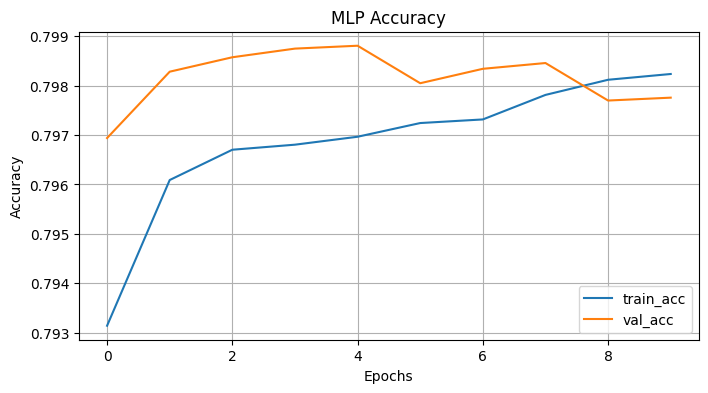

Epoch 1/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7691 - loss: 0.5184 - val_accuracy: 0.7981 - val_loss: 0.4608
Epoch 2/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7980 - loss: 0.4645 - val_accuracy: 0.7983 - val_loss: 0.4571
Epoch 3/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7991 - loss: 0.4577 - val_accuracy: 0.7983 - val_loss: 0.4546
Epoch 4/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7997 - loss: 0.4537 - val_accuracy: 0.7983 - val_loss: 0.4523
Epoch 5/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7998 - loss: 0.4491 - val_accuracy: 0.7983 - val_loss: 0.4510
Epoch 6/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7995 - loss: 0.4473 - val_accuracy: 0.7984 - val_loss: 0.4504
Epoch 7/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7995 - loss: 0.4450 - val_accuracy: 0.7983 - val_loss: 0.4497
Epoch 8/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7996 - loss: 0.4438 - val_accuracy: 0.

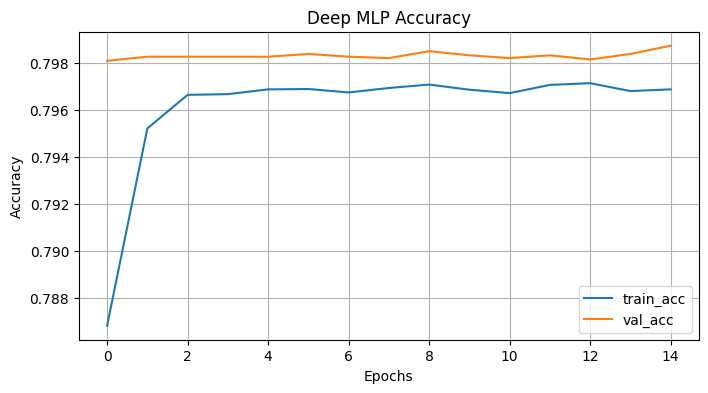

Epoch 1/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1847 - val_loss: 0.0775
Epoch 2/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0793 - val_loss: 0.0760
Epoch 3/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0783 - val_loss: 0.0754
Epoch 4/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0779 - val_loss: 0.0753
Epoch 5/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0774 - val_loss: 0.0739
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 2s 767us/step
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
Epoch 1/10
669/669 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7512 - loss: 0.5690 - val_accuracy: 0.7957 - val_loss: 0.4736
Epoch 2/10
669/669 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7950 - loss: 0.4765 - val_accuracy: 0.7958 - val_loss: 0.4709
Epoch 3/10
669/669 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7961 - loss: 0.4730 - val_accuracy: 0.7961 - val_loss: 0.4685
Epoch 4/10
669/669 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7958 - loss: 0.4701 - val_accuracy: 0

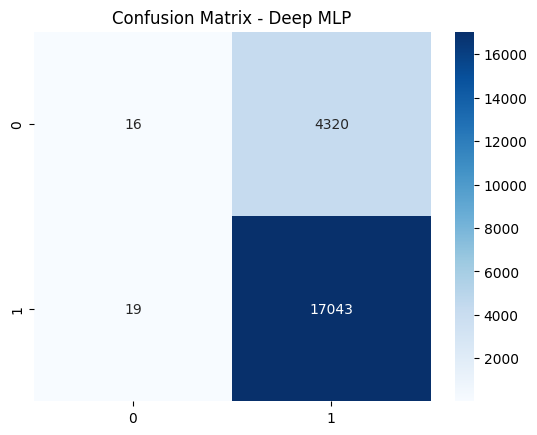

In [6]:
# ==========================
# Deep Learning for Missed Appointment Prediction
# ==========================

# Colab: Upload dataset if not present
try:
    import google.colab, os
    from google.colab import files
    if not os.path.exists("healthcare_noshows.csv"):
        print("Upload healthcare_noshows.csv")
        uploaded = files.upload()
except:
    pass

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ----------------- Load Data -----------------
df = pd.read_csv("healthcare_noshows.csv")
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# rename typos
if "Hipertension" in df.columns:
    df.rename(columns={"Hipertension":"Hypertension"}, inplace=True)
if "Handcap" in df.columns:
    df.rename(columns={"Handcap":"Handicap"}, inplace=True)

# parse dates
for c in ["ScheduledDay","AppointmentDay"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# target
if "Showed_up" not in df.columns:
    raise ValueError("Expected 'Showed_up' column as target (1=show,0=no-show)")
y = df["Showed_up"].astype(int)

# features
drop_cols = ["PatientId","AppointmentID","Showed_up"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# feature engineering
if set(["ScheduledDay","AppointmentDay"]).issubset(df.columns):
    X["wait_days"] = (df["AppointmentDay"].dt.normalize() - X["ScheduledDay"].dt.normalize()).dt.days.clip(lower=0)
    X["scheduled_hour"] = X["ScheduledDay"].dt.hour
    X["appointment_dow"] = X["AppointmentDay"].dt.dayofweek
    X["appointment_is_weekend"] = (X["appointment_dow"]>=5).astype(int)

X = X.drop(columns=["ScheduledDay","AppointmentDay"], errors="ignore")

# numeric/cat split
cat_cols = [c for c in X.columns if X[c].dtype=="object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# preprocess
num_proc = Pipeline([("scaler", StandardScaler())])
cat_proc = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
preproc = ColumnTransformer([("num", num_proc, num_cols), ("cat", cat_proc, cat_cols)], remainder="drop")

X_proc = preproc.fit_transform(X)
print("Processed shape:", X_proc.shape)

X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, stratify=y, random_state=42)

# ----------------- Helper: Training Plot -----------------
def plot_history(hist, title="Model"):
    plt.figure(figsize=(8,4))
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
    plt.show()

# ----------------- 1. Basic MLP -----------------
def build_mlp(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

mlp = build_mlp(X_train.shape[1])
hist = mlp.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=1)
plot_history(hist, "MLP")

# ----------------- 2. Deep MLP with Dropout & BatchNorm -----------------
def build_deep_mlp(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model

deep_mlp = build_deep_mlp(X_train.shape[1])
hist2 = deep_mlp.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=128, verbose=1)
plot_history(hist2, "Deep MLP")

# ----------------- 3. Autoencoder + Classifier -----------------
encoding_dim = 16
input_dim = X_train.shape[1]

inp = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation="relu")(inp)
encoded = layers.Dense(encoding_dim, activation="relu")(encoded)
decoded = layers.Dense(64, activation="relu")(encoded)
decoded = layers.Dense(input_dim, activation="sigmoid")(decoded)
autoencoder = keras.Model(inp, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(X_train, X_train, epochs=5, batch_size=256, shuffle=True, validation_data=(X_test,X_test), verbose=1)

encoder = keras.Model(inp, encoded)
X_train_enc = encoder.predict(X_train)
X_test_enc = encoder.predict(X_test)

clf = keras.Sequential([
    layers.Input(shape=(encoding_dim,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
clf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
clf.fit(X_train_enc, y_train, validation_data=(X_test_enc,y_test), epochs=10, batch_size=128, verbose=1)

# ----------------- 4. CNN (reshape as 1D sequence) -----------------
X_train_cnn = X_train.reshape((-1, X_train.shape[1],1))
X_test_cnn = X_test.reshape((-1, X_test.shape[1],1))

cnn = keras.Sequential([
    layers.Conv1D(32, 3, activation="relu", input_shape=(X_train.shape[1],1)),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn.fit(X_train_cnn, y_train, validation_data=(X_test_cnn,y_test), epochs=10, batch_size=128, verbose=1)

# ----------------- 5. LSTM (simulate temporal seq with padded features) -----------------
# NOTE: This is artificial (features not true sequence), but included as per prompt.
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)

lstm = keras.Sequential([
    layers.LSTM(64, input_shape=(1,X_train.shape[1])),
    layers.Dense(1, activation="sigmoid")
])
lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm.fit(X_train_lstm, y_train, validation_data=(X_test_lstm,y_test), epochs=10, batch_size=128, verbose=1)

# ----------------- Evaluate best model -----------------
y_pred = deep_mlp.predict(X_test).ravel()
y_pred_bin = (y_pred>=0.5).astype(int)

print("\nClassification Report (Deep MLP):")
print(classification_report(y_test, y_pred_bin))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Deep MLP")
plt.show()

Initial shape: (106987, 15)
Columns: ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up', 'Date.diff']
After cleaning shape: (106987, 14)
Numeric cols: ['Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'Date.diff', 'wait_days', 'scheduled_hour', 'appointment_dow', 'appointment_is_weekend']
Categorical cols: ['Gender', 'Neighbourhood']
Processed features shape: (106987, 95)
Train size: (85589, 95)  Test size: (21398, 95)

=== Voting Classifier ===
              precision    recall  f1-score   support

           0       0.47      0.19      0.27      4336
           1       0.82      0.94      0.88     17062

    accuracy                           0.79     21398
   macro avg       0.65      0.57      0.58     21398
weighted avg       0.75      0.79      0.76     21398

ROC-AUC: 0.7461851199510706

=== Bag

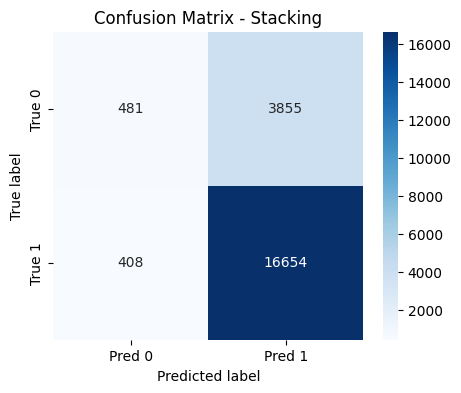

Saved model comparison to outputs_ensembles


In [10]:
# ==============================
# Ensemble Techniques for Missed Appointment Prediction (Corrected)
# ==============================

# If running in Colab and the CSV isn't present, this will prompt upload.
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import files
    import os
    if not os.path.exists("healthcare_noshows.csv"):
        print("Upload 'healthcare_noshows.csv' now (choose file in dialog)...")
        uploaded = files.upload()
        print("Uploaded:", list(uploaded.keys()))

# ---- imports ----
import os, warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

# Optional XGBoost (use if available)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ---- Load dataset ----
CSV_PATH = "healthcare_noshows.csv"
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"File not found: {CSV_PATH} — upload it to the runtime or update CSV_PATH.")

df = pd.read_csv(CSV_PATH)
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# ---- Basic cleaning & feature engineering ----
# Rename known misspellings
if "Hipertension" in df.columns:
    df.rename(columns={"Hipertension": "Hypertension"}, inplace=True)
if "Handcap" in df.columns:
    df.rename(columns={"Handcap": "Handicap"}, inplace=True)

# Parse datetimes if present
for c in ["ScheduledDay", "AppointmentDay"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Target: keep original "Showed_up" (1 = showed) as the label to predict.
if "Showed_up" not in df.columns:
    raise ValueError("Expected 'Showed_up' column in dataset (1=show, 0=no-show).")

y = df["Showed_up"].astype(int)

# Drop ID columns and target from features
drop_cols = ["PatientId", "AppointmentID", "Showed_up"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Add derived features if possible
if set(["ScheduledDay", "AppointmentDay"]).issubset(df.columns):
    X["wait_days"] = (df["AppointmentDay"].dt.normalize() - df["ScheduledDay"].dt.normalize()).dt.days.clip(lower=0).fillna(0).astype(int)
    X["scheduled_hour"] = df["ScheduledDay"].dt.hour.fillna(0).astype(int)
    X["appointment_dow"] = df["AppointmentDay"].dt.dayofweek.fillna(0).astype(int)
    X["appointment_is_weekend"] = (X["appointment_dow"] >= 5).astype(int)

# Drop raw datetimes to avoid dtype problems
X = X.drop(columns=["ScheduledDay", "AppointmentDay"], errors="ignore")

# Ensure binary columns numeric
for col in ["Hypertension", "Diabetes", "Alcoholism", "Handicap", "Scholarship", "SMS_received", "Date.diff"]:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="coerce").fillna(0).astype(int).clip(lower=0)

# Age sanity
if "Age" in X.columns:
    X = X[(X["Age"] >= 0) & (X["Age"] <= 120)]

print("After cleaning shape:", X.shape)

# ---- Preprocessing: numeric + categorical pipelines ----
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

num_pipeline = Pipeline([("scaler", StandardScaler())])

# OneHotEncoder has different param names across sklearn versions:
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipeline = Pipeline([("onehot", ohe)])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols),
    ],
    remainder="drop"
)

X_proc = preproc.fit_transform(X)
print("Processed features shape:", X_proc.shape)

# ---- Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.20, stratify=y, random_state=42)
print("Train size:", X_train.shape, " Test size:", X_test.shape)

# ---- Base learners ----
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# use XGBoost only if available; avoid deprecated parameter 'use_label_encoder'
if HAS_XGB:
    xgb = XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False)
else:
    xgb = None

# ---- Voting Classifier (soft voting) ----
estimators = [("lr", lr), ("rf", rf)]
if xgb is not None:
    estimators.append(("xgb", xgb))

voting = VotingClassifier(estimators=estimators, voting="soft", n_jobs=-1)
voting.fit(X_train, y_train)
y_pred_vote = voting.predict(X_test)
y_proba_vote = voting.predict_proba(X_test)[:,1]

print("\n=== Voting Classifier ===")
print(classification_report(y_test, y_pred_vote))
try:
    print("ROC-AUC:", roc_auc_score(y_test, y_proba_vote))
except Exception:
    print("ROC-AUC: N/A (predict_proba not available)")

# ---- Bagging Classifier (use 'estimator' param, not base_estimator) ----
bag = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42, n_jobs=-1)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
# Some bagging classifiers do not provide predict_proba for all base estimators:
try:
    y_proba_bag = bag.predict_proba(X_test)[:,1]
    auc_bag = roc_auc_score(y_test, y_proba_bag)
except Exception:
    y_proba_bag = None
    auc_bag = "N/A"

print("\n=== Bagging Classifier ===")
print(classification_report(y_test, y_pred_bag))
print("ROC-AUC:", auc_bag)

# ---- Stacking Classifier ----
stack_estimators = [("lr", lr), ("rf", rf)]
if xgb is not None:
    stack_estimators.append(("xgb", xgb))

# final estimator: logistic regression
stack = StackingClassifier(estimators=stack_estimators, final_estimator=LogisticRegression(max_iter=1000), cv=3, n_jobs=-1, passthrough=False)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
try:
    y_proba_stack = stack.predict_proba(X_test)[:,1]
    auc_stack = roc_auc_score(y_test, y_proba_stack)
except Exception:
    y_proba_stack = None
    auc_stack = "N/A"

print("\n=== Stacking Classifier ===")
print(classification_report(y_test, y_pred_stack))
print("ROC-AUC:", auc_stack)

# ---- Comparison table ----
results = {
    "Voting": {"accuracy": accuracy_score(y_test, y_pred_vote), "auc": roc_auc_score(y_test, y_proba_vote) if y_proba_vote is not None else np.nan},
    "Bagging": {"accuracy": accuracy_score(y_test, y_pred_bag), "auc": (roc_auc_score(y_test, y_proba_bag) if y_proba_bag is not None else np.nan)},
    "Stacking": {"accuracy": accuracy_score(y_test, y_pred_stack), "auc": (roc_auc_score(y_test, y_proba_stack) if y_proba_stack is not None else np.nan)}
}
results_df = pd.DataFrame(results).T
print("\nModel comparison:\n", results_df)

# ---- Confusion matrix for the best model (by accuracy) ----
best_model_name = results_df["accuracy"].idxmax()
best_pred = {"Voting": y_pred_vote, "Bagging": y_pred_bag, "Stacking": y_pred_stack}[best_model_name]

cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title(f"Confusion Matrix - {best_model_name}")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.show()

# ---- Save model comparison ----
outdir = "outputs_ensembles"
os.makedirs(outdir, exist_ok=True)
results_df.to_csv(os.path.join(outdir, "ensemble_comparison.csv"))
print("Saved model comparison to", outdir)